In [1]:
# import package
import os
import cv2
from tqdm import tqdm
import numpy as np
import pandas as pd
import PIL.Image as Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.metrics import accuracy_score, confusion_matrix

In [1]:
# 遇到 ImportError: libGL.so.1: cannot open shared object file: No such file or directory 可以執行以下指令解決：
!sudo apt-get update
!sudo apt-get install libgl1

Hit:1 http://security.ubuntu.com/ubuntu noble-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu noble InRelease
Hit:3 http://archive.ubuntu.com/ubuntu noble-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu noble-backports InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1 is already the newest version (1.7.0-1build1).
0 upgraded, 0 newly installed, 0 to remove and 153 not upgraded.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
print(device)

cuda


# TWCC環境

In [3]:
# 使用國網環境，請確定已經下載好Simpson dataset
# 預設資料集就是與此notebook檔案同樣的路徑底下
data_dir = './'
data_path = os.path.join(data_dir, 'simpsons_dataset/')

# 先確定好模型儲存的路徑，預設儲存在與notebook檔案同樣的路徑底下

#模型儲存路徑
model_dir = './model-logs/VGG16'

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# save model
modelfiles = model_dir + '/basic_model-best-model.pth'

# 一、Load Data

## 1. 將圖片路徑以及標籤個存取在陣列裡面
`x_data_list` : 圖片的路徑

`y_data_lsit` : 圖片的標籤

In [4]:

image_shape = 224

In [5]:
x_data_list = [] #圖片的路徑
y_data_list = [] #圖片的標籤

# data_path = './simpsons_dataset'
# os.path.join(data_path,dir) = './simpsons_dataset/abraham_grampa_simpson'

for dir in os.listdir(data_path): 
    for img in os.listdir(os.path.join(data_path,dir)): 
        x_data_list.append(os.path.join(data_path,dir,img))
        y_data_list.append(dir)


## 2. List to DataFrame

In [6]:
data_list = pd.DataFrame({})
data_list['img_path'] = x_data_list
data_list['label'] = y_data_list
data_list


,img_path,label
0,./simpsons_dataset/charles_montgomery_burns/pi...,charles_montgomery_burns
1,./simpsons_dataset/charles_montgomery_burns/pi...,charles_montgomery_burns
2,./simpsons_dataset/charles_montgomery_burns/pi...,charles_montgomery_burns
3,./simpsons_dataset/charles_montgomery_burns/pi...,charles_montgomery_burns
4,./simpsons_dataset/charles_montgomery_burns/pi...,charles_montgomery_burns
...,...,...
20928,./simpsons_dataset/ralph_wiggum/pic_0038.jpg,ralph_wiggum
20929,./simpsons_dataset/ralph_wiggum/pic_0037.jpg,ralph_wiggum
20930,./simpsons_dataset/ralph_wiggum/pic_0083.jpg,ralph_wiggum
20931,./simpsons_dataset/ralph_wiggum/pic_0078.jpg,ralph_wiggum


# 二、資料預處理

## 1. Train Test Split

In [7]:
from sklearn.model_selection import train_test_split

train_list, test_list = train_test_split(data_list,
                                         test_size=0.2,
                                         random_state=42,
                                         #按比例分配，如Labela, Labelb的比例是2:1, 則train and test的 Labela, Labelb的比例都會是2:1
                                         stratify=data_list['label'].values,
                                         shuffle = True)
print(len(train_list),len(test_list))


16746 4187


In [8]:
#  train_list
# DataFrame

In [9]:
# 裝入list
X_Train = []; y_Train = []
X_Test = []; y_Test = []

for i in range(len(train_list)):
    X_Train.append(train_list.iloc[i].img_path)
    y_Train.append(train_list.iloc[i].label)
    
for i in range(len(test_list)):
    X_Test.append(test_list.iloc[i].img_path)
    y_Test.append(test_list.iloc[i].label)

In [10]:
print(X_Train[:10])
print(y_Train[:10])

['./simpsons_dataset/moe_szyslak/pic_0379.jpg', './simpsons_dataset/milhouse_van_houten/pic_0078.jpg', './simpsons_dataset/charles_montgomery_burns/pic_0668.jpg', './simpsons_dataset/lenny_leonard/pic_0236.jpg', './simpsons_dataset/principal_skinner/pic_0540.jpg', './simpsons_dataset/principal_skinner/pic_0379.jpg', './simpsons_dataset/moe_szyslak/pic_0910.jpg', './simpsons_dataset/chief_wiggum/pic_0691.jpg', './simpsons_dataset/lisa_simpson/pic_0494.jpg', './simpsons_dataset/bart_simpson/pic_0546.jpg']
['moe_szyslak', 'milhouse_van_houten', 'charles_montgomery_burns', 'lenny_leonard', 'principal_skinner', 'principal_skinner', 'moe_szyslak', 'chief_wiggum', 'lisa_simpson', 'bart_simpson']


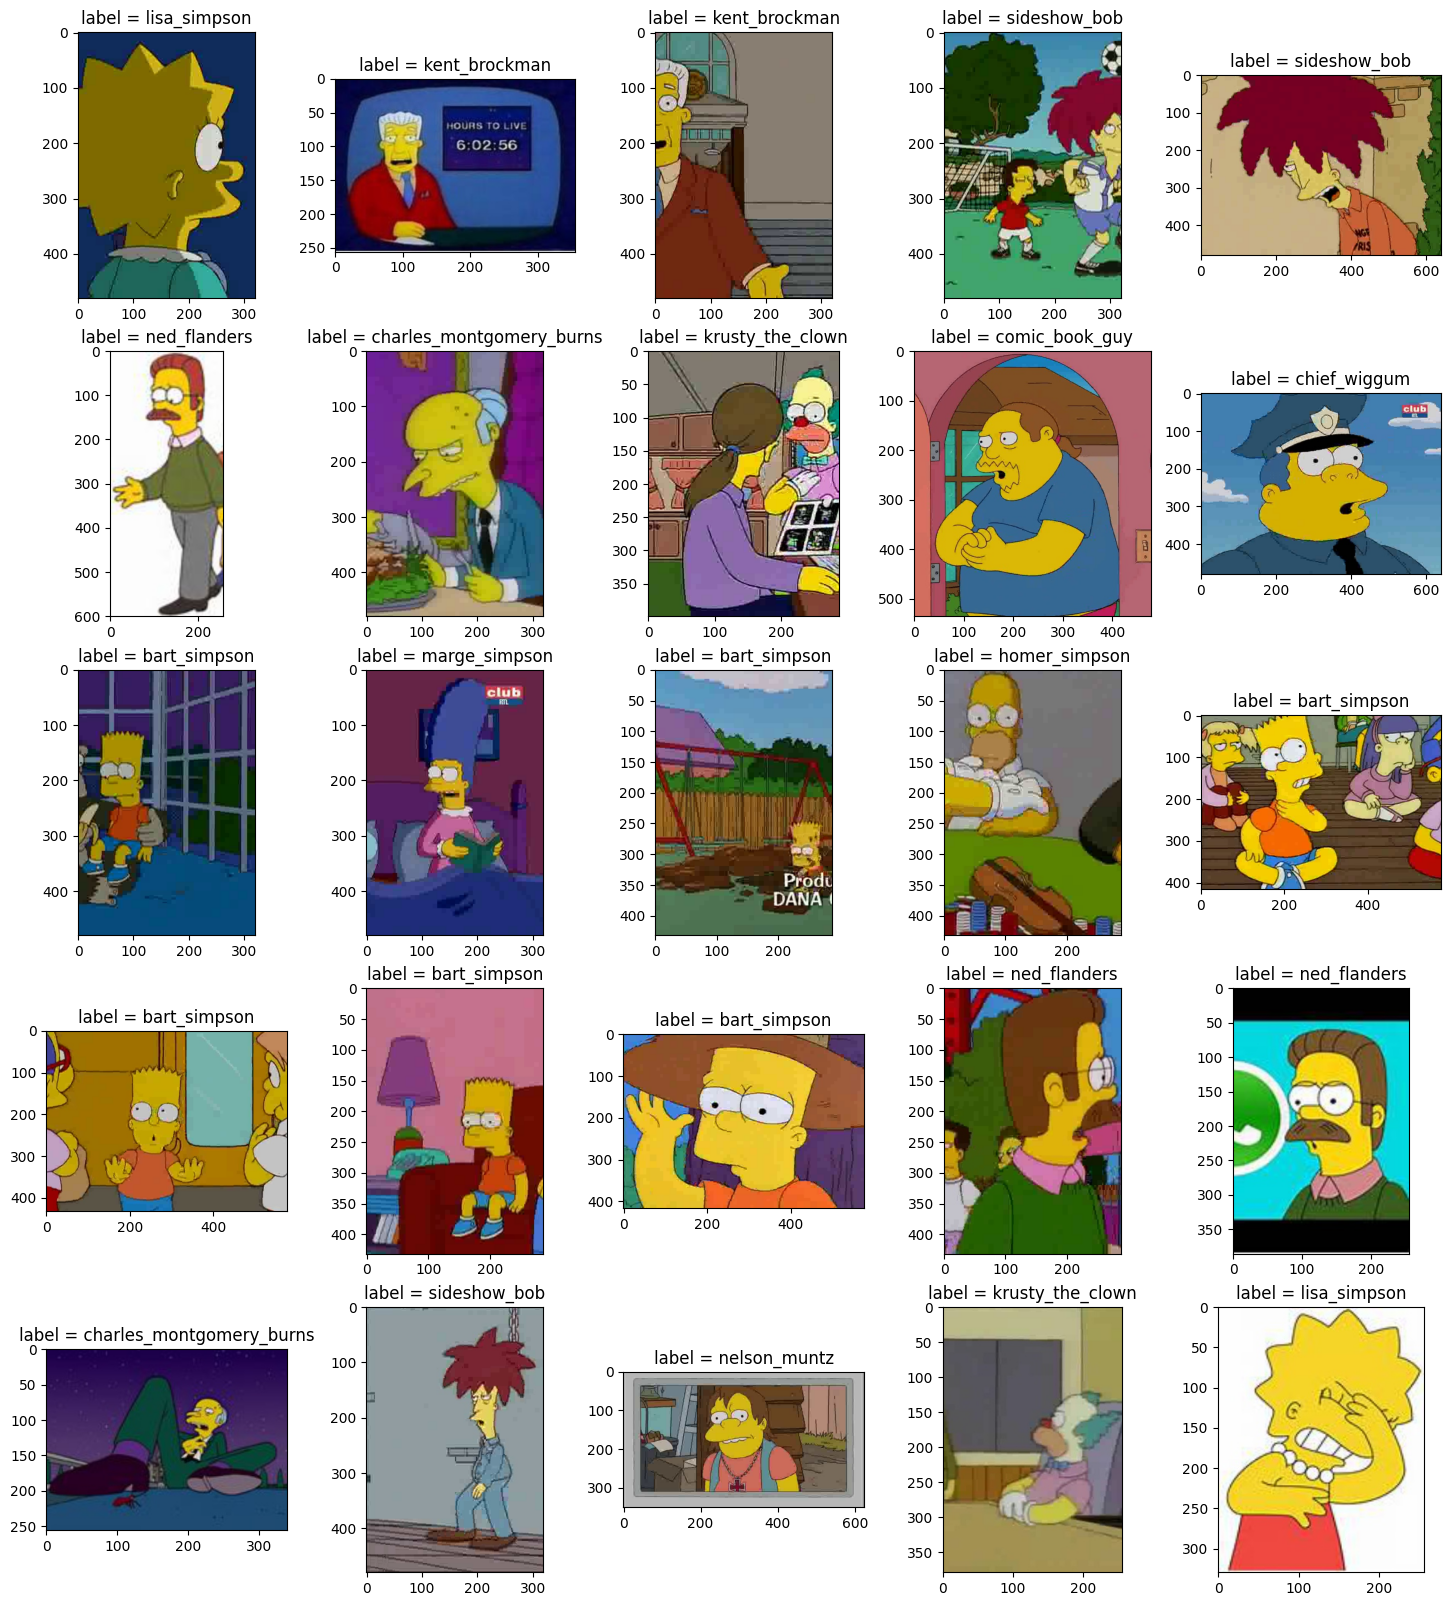

In [11]:
#隨機查看圖片
import random
def ShowImage(images,labels,total=10): #圖片，標籤，預測標籤，總共顯示張數
    plt.gcf().set_size_inches(18, 20)
    if total >=25:
        total = 25
    for i in range(0,total):
        num = random.randint(0,len(labels)-1)
        img_show = plt.subplot(5, 5, i+1)
        Img = cv2.imread(images[num])
        img_show.imshow(Img[:,:,::-1])
        title = "label = "+str(labels[num])
        plt.title(title)
    plt.show()

ShowImage(X_Train,y_Train,total=25)

## 2. 標籤的Number Encoding

In [12]:
# 檢查有多少類別  編號 'otto_mann' :1 
label_dict = {}

Count = 0
for i in range(len(data_list)):
    if data_list.iloc[i].label in label_dict:
        continue
    else:
        label_dict[data_list.iloc[i].label] = Count
        Count += 1

In [13]:
# label_dict

In [14]:
# 訓練完之後  要對應回去
labelreverse = {v: k for k, v in label_dict.items()}
# labelreverse

## 3. 建立預處理功能以及建立data loader

https://pytorch.org/hub/pytorch_vision_vgg/

In [15]:
# 訓練集的預處理及資料擴增
# resize的default為PIL.Image.BILINEAR
# 官方大數據算出來的mean  std
# 隨機對圖像進行仿射變換。這些變換包括旋轉、平移、縮放和剪切。
preprocess_train = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.Resize((image_shape,image_shape)),
                                       transforms.RandomAffine(degrees=(-30,30), translate=(0.1, 0.1), scale=(0.9, 1.5), shear=(0,0)),])
          

# 測試集的預處理
preprocess_test = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                      transforms.Resize((image_shape,image_shape)),])

In [16]:
def default_loader(path, preprocess_function):
    # 使用cv2讀取圖片
    img_pil = cv2.imread(path)
    # 將BGR 轉換成 RGB
    img_pil = cv2.cvtColor(img_pil, cv2.COLOR_BGR2RGB)
    # 將前面的預處理方式加入圖片中
    img_tensor = preprocess_function(img_pil)
    return img_tensor

In [17]:
# Custom_Generator  提供模型訓練資料
class Custom_Generator(Dataset):
    def __init__(self, image_file, image_label, label_dict, pre_fn, loader = default_loader):
        
        self.images = image_file      # 圖片路徑的陣列
        self.target = image_label     # 圖片標籤的陣列
        self.label_dict = label_dict  # 如：{'dogs': 0, 'cats': 1}
        self.pre_fn = pre_fn          # 資料預處理
        self.loader = loader          # 讀圖片的function

    def __getitem__(self, index):
        fn = self.images[index]      # 圖片路徑
        
        img = self.loader(path = fn, # 圖片讀取以及預處理後的結果，輸入模型用
                          preprocess_function = self.pre_fn)
        
        target = self.label_dict[self.target[index]] # 圖片標籤, 並轉換成數字
        
        return img,target

    def __len__(self):
        return len(self.images)     # 回傳資料集數量

In [18]:
# 1. 先呼叫我們寫好的Custom_Generator, 將圖片的路徑陣列、圖片的標籤陣列以及預處理功能放入裡面
train_data  = Custom_Generator(image_file = X_Train, 
                               image_label = y_Train, 
                               label_dict = label_dict,
                               pre_fn = preprocess_train)

# 2. 呼叫pytorch的DataLoader來做批次動作，模型的輸入
trainloader = DataLoader(train_data, batch_size=128,shuffle=True)

# 1. 先呼叫我們寫好的Custom_Generator, 將圖片的路徑陣列、圖片的標籤陣列以及預處理功能放入裡面
test_data  = Custom_Generator(image_file = X_Test, 
                              image_label = y_Test, 
                              label_dict = label_dict,
                              pre_fn = preprocess_test)

# 2. 呼叫pytorch的DataLoader來做批次動作，模型的輸入
testloader = DataLoader(test_data, batch_size=128,shuffle=False)



# 三、載入預訓練模型
Use `VGG-16` for Transfer learning

## 1. 讀入模型

In [19]:
import torchvision.models as models

In [20]:
# # 加載已經在 ImageNet 資料集上預訓練的權重
# cnn_model = models.vgg16(pretrained=True)

# # 要先去查看原始cnn_model的全連接層名稱
# cnn_model
# #cnn_model.classifier

@@ 

In [21]:
# 加載已經在 ImageNet 資料集上預訓練的權重
cnn_model = models.vgg16(pretrained=True)

# 要先去查看原始cnn_model的全連接層名稱
cnn_model.classifier = nn.Sequential(nn.Linear(in_features = 25088, out_features = 128), 
                                     nn.ReLU(True),
                                     nn.Dropout(),
                                     nn.Linear(in_features = 128, out_features = len(labelreverse)),)
cnn_model.to(device)
summary(cnn_model, input_size=(3, image_shape, image_shape))

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

## 2. 決定要Fine tune Freeze的layer(如果不Freezing可以略過這一步)
這個要判斷今天的資料集狀況再決定是否要對預訓練模型的layer做Freezing

In [22]:
# 可以先查看所有layers的名稱
# cnn_model.named_parameters()  模型中所有參數的名字和參數本身
# param.requires_grad：這個屬性表示該參數是否需要計算梯度（即是否可訓練）。
# print(name)：打印出所有可訓練參數的名字。
# param.requires_grad 是一個布林值，指示該參數是否需要計算梯度
for name, param in cnn_model.named_parameters():
    if param.requires_grad:
        print(name)
        
print(cnn_model)

features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
features.12.weight
features.12.bias
features.14.weight
features.14.bias
features.17.weight
features.17.bias
features.19.weight
features.19.bias
features.21.weight
features.21.bias
features.24.weight
features.24.bias
features.26.weight
features.26.bias
features.28.weight
features.28.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3

# 先不要執行這部分

In [23]:
# 再決定要layer freeze哪幾層
for name, param in cnn_model.named_parameters():
    if param.requires_grad and name == 'features.10.weight':
        break
    elif param.requires_grad:
        print(name)
        param.requires_grad = False   # 將參數設置為不可訓練（凍結）。
        
cnn_model.to(device)
summary(cnn_model, input_size=(3, image_shape, image_shape))

features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [

## 2. 決定 Loss function 、Optimizer

In [23]:
# 選用Adam為optimizer
# Parameters
# pytorch的CrossEntropyLoss在計算時，會以softmax的輸出作為最後的結果

criterion = nn.CrossEntropyLoss()
lr = 0.0001  # @@ 小一點 因為是 做微調
epochs = 10
#optimizer_cnn = optim.SGD(cnn_model.parameters(), lr=lr, momentum=0.9)
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_cnn, 
                                                       mode='min', 
                                                       factor=0.1, 
                                                       patience=3, 
                                                       verbose=True)


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## 4. 開始訓練囉！

In [24]:
def PrintLogMessage(Now_epoch, Total_epoch, Now_itr, Total_itr, loss, acc, train = True, flush = False):
    if train == True and flush == True:
        print('[%02d/%02d, %d/%d] loss: %.3f, acc: %.3f' % (Now_epoch, Total_epoch, Now_itr, Total_itr, loss,acc),end = "")
        print("\r", end="", flush=True)
    elif train == True and flush == False:
        print('[%02d/%02d, %d/%d] loss: %.3f, acc: %.3f' % (Now_epoch, Total_epoch, Now_itr, Total_itr, loss,acc),end = "")
    elif train == False:
        print(', test_loss: %.3f, test_acc: %.3f' % (loss,acc))
        

In [25]:
# 訓練過程
# len(trainLoader) : 訓練集總共的資料量 / batch
# len(trainLoader.dataset) : 訓練集總共的資料量

Best_Acc = 0
cnn_loss_history = []
cnn_acc_history = []

cnn_valloss_history = []
cnn_valacc_history = []

for epoch in range(epochs):
    # 訓練階段
    cnn_model.train()
    running_loss = 0.0
    accuracy = 0.0
    total = 0.0

    for times, data_train in enumerate(trainloader, 0):
        # batch data input
        inputs, labels = data_train
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer_cnn.zero_grad()

        # model Feedforward
        output_train = cnn_model(inputs)
        # Feed forward loss result
        loss = criterion(output_train, labels)
        
        # backward update
        loss.backward()
        
        # optimize
        optimizer_cnn.step()

        # Compute loss
        running_loss += loss.item()
        
        # Compute accuracy
        _, predicted = torch.max(output_train.data, 1)
        total += labels.size(0)
        accuracy += (predicted == labels).sum().item()
        
        # Print log message
        PrintLogMessage(Now_epoch = epoch+1, 
                        Total_epoch = epochs, 
                        Now_itr = times+1, 
                        Total_itr = len(trainloader), 
                        loss = running_loss/(times+1), 
                        acc = accuracy / total, 
                        train = True, 
                        flush = True)
        if times+1 == len(trainloader):
            # Print log message
            PrintLogMessage(Now_epoch = epoch+1, 
                            Total_epoch = epochs, 
                            Now_itr = times+1, 
                            Total_itr = len(trainloader), 
                            loss = running_loss/(times+1), 
                            acc = accuracy / total, 
                            train = True, 
                            flush = False)
            cnn_loss_history.append(running_loss/len(trainloader))
            cnn_acc_history.append(accuracy / total)
            running_loss = 0.0

    # 測試階段
    cnn_model.eval()
    test_loss = 0.0
    accuracy = 0.0
    total = 0.0
    with torch.no_grad(): # disable gradient calculation for efficiency
        for times, data_test in enumerate(testloader, 0):
            # batch data input
            inputs, labels = data_test
            inputs, labels = inputs.to(device), labels.to(device)
            
            # model predict    
            output_test = cnn_model(inputs)
            
            # Compute loss
            loss_t = criterion(output_test, labels)
            test_loss += loss_t.item()
            
            # Compute accuracy
            _, predicted = torch.max(output_test.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
            
            if times+1 == len(testloader):
                scheduler.step(test_loss / len(testloader))
                # Print log message
                PrintLogMessage(Now_epoch = epoch+1, 
                                Total_epoch = epochs, 
                                Now_itr = times+1, 
                                Total_itr = len(testloader), 
                                loss = test_loss/(times+1), 
                                acc = accuracy / total, 
                                train = False, 
                                flush = False)
                # if (accuracy / total) > Best_Acc:
                #     Best_Acc = (accuracy / total)
                #     torch.save(cnn_model, modelfiles)
                #     print("Save Model!")
                
                cnn_valloss_history.append(test_loss / len(testloader))
                cnn_valacc_history.append(accuracy / total)
                test_loss = 0.0

print('Finished Training')

[01/10, 131/131] loss: 1.980, acc: 0.497, test_loss: 0.761, test_acc: 0.820
[02/10, 131/131] loss: 0.749, acc: 0.822, test_loss: 0.458, test_acc: 0.892
[03/10, 131/131] loss: 0.503, acc: 0.882, test_loss: 0.377, test_acc: 0.918
[04/10, 131/131] loss: 0.388, acc: 0.907, test_loss: 0.255, test_acc: 0.937
[05/10, 131/131] loss: 0.310, acc: 0.923, test_loss: 0.218, test_acc: 0.949
[06/10, 131/131] loss: 0.244, acc: 0.943, test_loss: 0.183, test_acc: 0.959
[07/10, 131/131] loss: 0.215, acc: 0.947, test_loss: 0.180, test_acc: 0.958
[08/10, 131/131] loss: 0.190, acc: 0.953, test_loss: 0.160, test_acc: 0.963
[09/10, 131/131] loss: 0.183, acc: 0.956, test_loss: 0.163, test_acc: 0.961
[10/10, 131/131] loss: 0.157, acc: 0.963, test_loss: 0.156, test_acc: 0.969
Finished Training


# 四、查看模型訓練結果

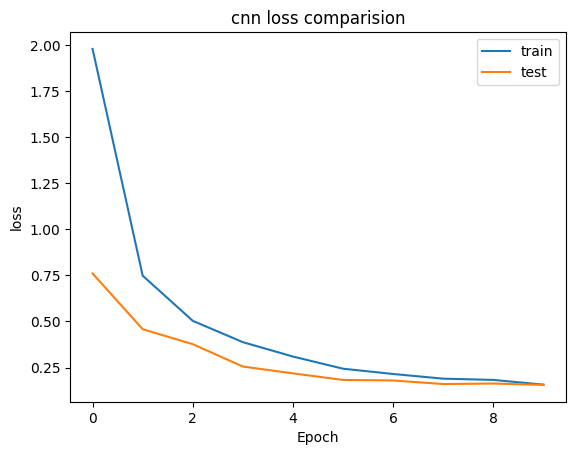

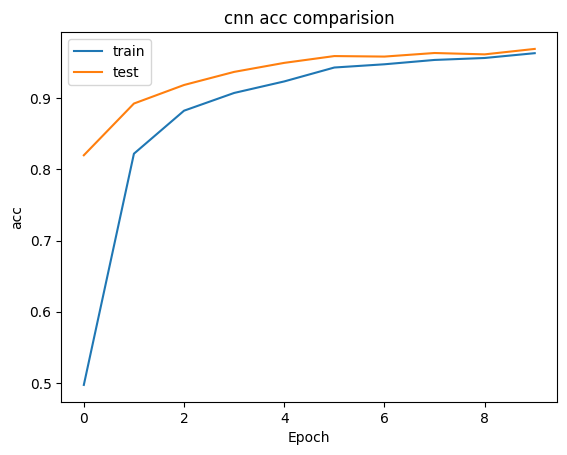

In [26]:
def Show_Train_flow(train_cnnmodel, test_cnnmodel, Show = 'loss', Title='Training accuracy comparision'):
    plt.plot(train_cnnmodel)
    plt.plot(test_cnnmodel)
    plt.title(Title)
    plt.ylabel(Show)
    plt.xlabel('Epoch')
    plt.legend(['train','test'])
    plt.show()
    
Show_Train_flow(cnn_loss_history, cnn_valloss_history, Show = 'loss', Title='cnn loss comparision')
Show_Train_flow(cnn_acc_history, cnn_valacc_history, Show = 'acc', Title='cnn acc comparision')

# 五、測試模型
在訓練好模型後，我們一定會拿測試集來測試一下我們訓練模型的好壞

現在就是要使用`kaggle_simpson_testset`來進行預測

## 1. 如果今天想要使用訓練好的模型的話，可以直接load_model


In [27]:
cnn_model = torch.load(modelfiles) # 事先訓練好的
cnn_model.to(device)
# Set model to eval mode  評估模式  ，Dropout 或 BatchNorm(會使用在訓練過程中學到的全局均值和標準差來進行歸一化。)   
cnn_model.eval()

/tmp/ipykernel_1300/981403915.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model = torch.load(modelfiles) # 事先訓練好的


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## 2. 將預測的資料集讀取下來，並轉換成dataframe形式
** 會全部先設定`class`為1是因為我們不知道標籤，所以先預設為1 **

In [28]:
#讀取圖片與 Label
testing_dir_path = os.path.join(data_dir, 'kaggle_simpson_testset/predict')
all_file = os.listdir(os.path.join(data_dir, 'kaggle_simpson_testset/predict'))

In [29]:
# 有原因的
all_file.sort()
test_df = pd.DataFrame({'file_path':all_file,'class':1}) 
test_df

,file_path,class
0,abraham_grampa_simpson_0.jpg,1
1,abraham_grampa_simpson_1.jpg,1
2,abraham_grampa_simpson_10.jpg,1
3,abraham_grampa_simpson_11.jpg,1
4,abraham_grampa_simpson_12.jpg,1
...,...,...
985,sideshow_bob_49.jpg,1
986,sideshow_bob_5.jpg,1
987,sideshow_bob_7.jpg,1
988,sideshow_bob_8.jpg,1


## 3. 將測試集讀入到data generator
因為沒有答案，所以務必將`class_mode`設定為`None`

In [30]:
from tqdm import tqdm

In [31]:
softmax_output = nn.Softmax(dim=1)

predict_output = []

for i in tqdm(range(len(test_df)),position=0):
    Img = cv2.imread(os.path.join(testing_dir_path,test_df.iloc[i].file_path))
    Img = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB)
    ImgTest = preprocess_test(Img)    # 將圖片轉換成torch tensor(才能丟入模型進行預測)  測試集的方法
    ImgTest = torch.unsqueeze(ImgTest, 0) # (3,224 ,224 ) ->(1,3,224 ,224 )  GPU 計算的時候 知道她是一張圖片
    ImgTest = ImgTest.to(device)          # to gpu mode
    Result = cnn_model(ImgTest)           # Predict images
    sm_Result = softmax_output(Result)    # softmax output
    
    sm_Result = sm_Result.data.cpu().numpy()
    predict_output.append(sm_Result[0].argmax())

100%|██████████| 990/990 [00:03<00:00, 290.32it/s]


In [32]:
# predict_output[:1]

In [33]:
#labelreverse

In [34]:
y_pred_label = [] # 設定一個將softmax結果轉換成標籤的陣列

for i in range(len(predict_output)):
    y_pred_label.append(labelreverse[predict_output[i]])
    
y_pred_label = np.array(y_pred_label)

In [35]:
test_df = pd.DataFrame({'file_path':all_file,'pred':y_pred_label})
test_df

,file_path,pred
0,abraham_grampa_simpson_0.jpg,abraham_grampa_simpson
1,abraham_grampa_simpson_1.jpg,abraham_grampa_simpson
2,abraham_grampa_simpson_10.jpg,abraham_grampa_simpson
3,abraham_grampa_simpson_11.jpg,abraham_grampa_simpson
4,abraham_grampa_simpson_12.jpg,abraham_grampa_simpson
...,...,...
985,sideshow_bob_49.jpg,sideshow_bob
986,sideshow_bob_5.jpg,sideshow_bob
987,sideshow_bob_7.jpg,sideshow_bob
988,sideshow_bob_8.jpg,sideshow_bob


# 六、評估模型

## 1. 讀取正確答案

In [36]:
correct_ans = pd.read_csv(data_dir + "ans.csv")
correct_ans

,file,class
0,sideshow_bob_13.jpg,sideshow_bob
1,lisa_simpson_26.jpg,lisa_simpson
2,abraham_grampa_simpson_40.jpg,abraham_grampa_simpson
3,principal_skinner_36.jpg,principal_skinner
4,kent_brockman_41.jpg,kent_brockman
...,...,...
985,edna_krabappel_21.jpg,edna_krabappel
986,apu_nahasapeemapetilon_9.jpg,apu_nahasapeemapetilon
987,mayor_quimby_19.jpg,mayor_quimby
988,ned_flanders_13.jpg,ned_flanders


In [37]:
correct_ans = correct_ans.sort_values(by=['file'])
correct_ans

,file,class
812,abraham_grampa_simpson_0.jpg,abraham_grampa_simpson
629,abraham_grampa_simpson_1.jpg,abraham_grampa_simpson
525,abraham_grampa_simpson_10.jpg,abraham_grampa_simpson
184,abraham_grampa_simpson_11.jpg,abraham_grampa_simpson
809,abraham_grampa_simpson_12.jpg,abraham_grampa_simpson
...,...,...
59,sideshow_bob_49.jpg,sideshow_bob
266,sideshow_bob_5.jpg,sideshow_bob
864,sideshow_bob_7.jpg,sideshow_bob
696,sideshow_bob_8.jpg,sideshow_bob


## 2. Confusion Matrix

In [38]:
# 將預測標籤與實際標籤儲存進陣列裡面
y_predict = [];y_TrueLabel=[]

y_TrueLabel = correct_ans['class'].values
y_predict = test_df['pred'].values

In [39]:
from sklearn.metrics import classification_report

y_TrueLabel = np.asarray(y_TrueLabel)
y_predict = np.asarray(y_predict)
print(classification_report(y_TrueLabel, y_predict, digits = 3))  

                          precision    recall  f1-score   support

  abraham_grampa_simpson      1.000     0.979     0.989        48
  apu_nahasapeemapetilon      1.000     1.000     1.000        50
            bart_simpson      1.000     0.980     0.990        50
charles_montgomery_burns      0.904     0.979     0.940        48
            chief_wiggum      1.000     0.980     0.990        50
          comic_book_guy      0.980     1.000     0.990        49
          edna_krabappel      1.000     0.960     0.980        50
           homer_simpson      0.943     1.000     0.971        50
           kent_brockman      1.000     1.000     1.000        50
        krusty_the_clown      0.980     1.000     0.990        50
           lenny_leonard      1.000     1.000     1.000        50
            lisa_simpson      0.980     1.000     0.990        50
           marge_simpson      1.000     1.000     1.000        50
            mayor_quimby      1.000     0.880     0.936        50
     milh

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [40]:
display(pd.crosstab(y_TrueLabel, y_predict, rownames=["True"], colnames=["Predict"]))

Predict,abraham_grampa_simpson,apu_nahasapeemapetilon,bart_simpson,charles_montgomery_burns,chief_wiggum,comic_book_guy,edna_krabappel,homer_simpson,kent_brockman,krusty_the_clown,...,lisa_simpson,marge_simpson,mayor_quimby,milhouse_van_houten,moe_szyslak,ned_flanders,nelson_muntz,principal_skinner,professor_john_frink,sideshow_bob
True,,,,,,,,,,,,,,,,,,,,,
abraham_grampa_simpson,47,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
apu_nahasapeemapetilon,0,50,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bart_simpson,0,0,49,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
charles_montgomery_burns,0,0,0,47,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
chief_wiggum,0,0,0,0,49,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
comic_book_guy,0,0,0,0,0,49,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
edna_krabappel,0,0,0,0,0,0,48,1,0,1,...,0,0,0,0,0,0,0,0,0,0
homer_simpson,0,0,0,0,0,0,0,50,0,0,...,0,0,0,0,0,0,0,0,0,0
kent_brockman,0,0,0,0,0,0,0,0,50,0,...,0,0,0,0,0,0,0,0,0,0
